In [ ]:
!pip install keras

In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [114]:
import pickle

In [115]:
filename = '/content/drive/My Drive/data.pkl'         ###load the whole data to create tokenizer
data = pickle.load(open(filename,'rb'))
data.shape

(70000, 2)

In [116]:
for i in range(len(data)):                    ###add start and end tokens in german to denote start and end of sequence
    data[i,1]='start '+ data[i,1] + ' end'

In [117]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [118]:
def create_tokens(lines):
    tokens = Tokenizer()        ###function to create tokens
    tokens.fit_on_texts(lines)
    return tokens

In [119]:
english_tokenizer = create_tokens(data[:,0])       ###fit a tokenizer
german_tokenizer = create_tokens(data[:,1])

In [120]:
def encode_sentences(tokens,length,lines):   ###function to pad the data to maximum phrase length
    X=tokens.texts_to_sequences(lines)
    X=pad_sequences(X,length,padding='post')
    return X    

In [121]:
def max_len_sen(data):                       ###function to calculate maximum length
    return max(len(line.split()) for line in data)

In [122]:
eng_vocab = len(english_tokenizer.word_index)+1
german_vocab = len(german_tokenizer.word_index)+1
print('Vocabulary size of english words is {}'.format(eng_vocab))
print('Vocabulary size of german words is {}'.format(german_vocab))

Vocabulary size of english words is 11417
Vocabulary size of german words is 21679


In [123]:
eng_len = max_len_sen(data[:,0])
ger_len = max_len_sen(data[:,1])
print ('Maximum length in English is {}'.format(eng_len))
print ('Maximum length in German is {}'.format(ger_len))

Maximum length in English is 44
Maximum length in German is 47


In [124]:
filename1 = '/content/drive/My Drive/eng-ger_train.pkl'                   ###load training, validation and test data
filename2 = '/content/drive/My Drive/eng-ger_val.pkl' 
filename3 = '/content/drive/My Drive/eng-ger_test.pkl'       
train = pickle.load(open(filename1,'rb'))
val = pickle.load(open(filename2,'rb'))
test = pickle.load(open(filename3,'rb'))
train.shape, val.shape, test.shape

((50000, 2), (10000, 2), (10000, 2))

In [125]:
for i in range(len(train)):                    ###add start and end tokens in german to denote start and end of sequence
    train[i,1]='start '+ train[i,1] + ' end'
for i in range(len(val)):                    ##convert to lowercase
    val[i,1]='start '+ val[i,1] + ' end'
for i in range(len(test)):                    ##convert to lowercase
    test[i,1]='start '+ test[i,1] + ' end'


In [126]:
X_train = encode_sentences(english_tokenizer,eng_len,train[:,0])          ###pad the data to maximum length
X_val = encode_sentences(english_tokenizer,eng_len,val[:,0])              ### X ---> English, Y ---> German
X_test= encode_sentences(english_tokenizer,eng_len,test[:,0])
Y_train = encode_sentences(german_tokenizer,ger_len,train[:,1])
Y_val = encode_sentences(german_tokenizer,ger_len,val[:,1])
Y_test = encode_sentences(german_tokenizer,ger_len,test[:,1])

In [127]:
print(X_train.shape)
print(X_val.shape)   ###check for dimensions
print(X_test.shape)
print(Y_train.shape)
print(Y_val.shape)
print(Y_test.shape)

(50000, 44)
(10000, 44)
(10000, 44)
(50000, 47)
(10000, 47)
(10000, 47)


In [128]:
from keras.models import Sequential, load_model,Model
from keras.layers import Embedding
from keras.layers import Dense, Dropout, LSTM, Bidirectional, RepeatVector, TimeDistributed, Concatenate
from keras.layers import Dropout,Input
from keras.callbacks import ModelCheckpoint
import numpy as np

In [129]:
def encoder_decoder(src_vocab_size, target_vocab_size, src_maxlen, target_maxlen, units):

  ###Encoder
    enc_input = Input((None,))         
    enc_embed = Embedding(src_vocab_size+1, units*2)
    encoder = Bidirectional(LSTM(units, return_state = True))
    enc_output, enc_hstate_f, enc_cstate_f,enc_hstate_b, enc_cstate_b = encoder(enc_embed(enc_input))
    enc_hstate = Concatenate()([enc_hstate_f,enc_hstate_b])
    enc_cstate = Concatenate()([enc_cstate_f,enc_cstate_b])
    encoder_states = [enc_hstate,enc_cstate]          ### ignore the output of the encoder and only keep states of LSTM at the last timestep
    encoder_model = Model(enc_input, encoder_states)

  ###Decoder
    dec_input = Input((None,))                       ###Inputs to the decoder
    decoder_hstate_input = Input((units*2,))
    decoder_cstate_input = Input((units*2,))
    decoder_states_input = [decoder_hstate_input, decoder_cstate_input]

    dec_embed = Embedding(target_vocab_size+1, units*2)
    decoder = LSTM(units*2,return_sequences = True, return_state = True)
    dec_fc = TimeDistributed(Dense(target_vocab_size,activation='softmax', kernel_initializer = 'glorot_uniform'))

    dec_z,dec_hstate,dec_cstate = decoder(dec_embed(dec_input), initial_state = decoder_states_input)      
    dec_states_output = [dec_hstate, dec_cstate]       ###states of decoder is used during inference
    dec_output = dec_fc(dec_z)
    dec_model = Model([dec_input]+decoder_states_input, [dec_output]+dec_states_output)    ###used in inference

  ###Encoder-Decoder Model
    target_token,_,_ = decoder(dec_embed(dec_input), initial_state = encoder_states)
    target = dec_fc(target_token)
    enc_dec_model = Model([enc_input, dec_input],target)

    return enc_dec_model, encoder_model, dec_model


In [130]:
enc_dec_model, encoder_model, dec_model = encoder_decoder(eng_vocab, german_vocab, eng_len, ger_len, units = 256)

In [131]:
enc_dec_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy')


In [132]:
filename = '/content/drive/My Drive/encoder-decoder(conditional).h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [133]:
enc_dec_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, None, 512)    5846016     input_9[0][0]                    
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) [(None, 512), (None, 1574912     embedding_5[0][0]                
____________________________________________________________________________________________

**Teacher Forcing while training**

In [134]:
target = Y_train[:,1:]                ###next word of the sequence will be the target for the decoder
dec_inp = Y_train[:,:-1]
print(X_train.shape)
print(dec_inp.shape)
print(target.shape)

(50000, 44)
(50000, 46)
(50000, 46)


In [135]:
target_val = Y_val[:,1:]
dec_val = Y_val[:,:-1]
print(X_val.shape)
print(dec_val.shape)
print(target_val.shape)

(10000, 44)
(10000, 46)
(10000, 46)


In [149]:
history= enc_dec_model.fit([X_train,dec_inp], target.reshape(target.shape[0], target.shape[1], 1), 
          epochs=25, batch_size=256, 
          validation_data = ([X_val, dec_val], target_val.reshape(target_val.shape[0],target_val.shape[1], 1)),
           verbose=1, callbacks=[checkpoint])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 136s 3ms/step - loss: 1.4136 - val_loss: 0.9571

Epoch 00001: val_loss improved from inf to 0.95713, saving model to /content/drive/My Drive/encoder-decoder(conditional).h5
Epoch 2/25
50000/50000 [==============================] - 140s 3ms/step - loss: 0.9100 - val_loss: 0.8695

Epoch 00002: val_loss improved from 0.95713 to 0.86950, saving model to /content/drive/My Drive/encoder-decoder(conditional).h5
Epoch 3/25
50000/50000 [==============================] - 142s 3ms/step - loss: 0.8229 - val_loss: 0.7965

Epoch 00003: val_loss improved from 0.86950 to 0.79651, saving model to /content/drive/My Drive/encoder-decoder(conditional).h5
Epoch 4/25
50000/50000 [==============================] - 142s 3ms/step - loss: 0.7456 - val_loss: 0.7340

Epoch 00004: val_loss improved from 0.79651 to 0.73403, saving model to /content/drive/My Drive/encoder-decoder(conditional).h5
Epoch 5/25
500

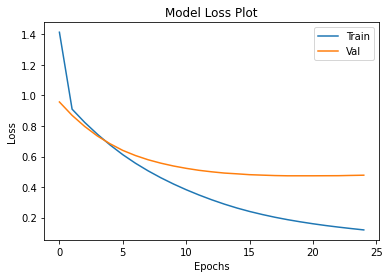

In [150]:
import matplotlib.pyplot as plt                             ###plot loss on train and val data
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'],loc = 'upper right')
plt.show()

In [151]:
from keras.models import load_model

In [152]:
model = load_model('/content/drive/My Drive/encoder-decoder(conditional).h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [153]:
from nltk.translate.bleu_score import corpus_bleu

In [154]:
def _init_states(enc_model, src_sentence, tokenizers, src_max_len):   ###initialise decoder state with encoder state
    
    src_tokenizer, tar_tokenizer = tokenizers
    src_index_word = src_tokenizer.index_word
    src_word_index = src_tokenizer.word_index 
    tar_index_word = tar_tokenizer.index_word
    tar_word_index = tar_tokenizer.word_index
    tar_token = 'start'
    tar_index = tar_word_index.get(tar_token, None)
    if tar_index == None:
        print('start token not found!')
    src_input_seq = src_tokenizer.texts_to_sequences([src_sentence])
    src_input_seq = pad_sequences(src_input_seq, maxlen=src_max_len, padding='post')
    states = enc_model.predict(src_input_seq)
    return ([tar_index], [tar_token], [1.0]), states

In [155]:
def _update_states(dec_model, tar_triple, states, tokenizers):    ###update decoder states after every timestep
  
    src_tokenizer, tar_tokenizer = tokenizers
    src_index_word = src_tokenizer.index_word
    src_word_index = src_tokenizer.word_index 
    tar_index_word = tar_tokenizer.index_word
    tar_word_index = tar_tokenizer.word_index
    tar_index, tar_token, tar_prob = tar_triple
    # predict the token probability, and states
    probs, state_h, state_c = dec_model.predict([[tar_index[-1]]] + states)
    states_new = [state_h, state_c]
    # update the triple
    probs = probs[0,-1,:]     # greedy search
    tar_index_new = np.argmax(probs)
    tar_token_new = tar_index_word.get(tar_index_new, None)
    tar_prob_new = probs[tar_index_new]
    tar_triple_new = ( 
        tar_index + [tar_index_new],
        tar_token + [tar_token_new],
        tar_prob + [tar_prob_new]
        )
    return tar_triple_new, states_new

In [156]:
def infer_lstm(src_sentence, enc_model, dec_model, tokenizers, max_len):
    
    src_max_len, tar_max_len = max_len
    # initialize with encoder states
    tr, ss = _init_states(enc_model, src_sentence, tokenizers, src_max_len)
    for i in range(tar_max_len):
        # update the triple and states of decoder
        tr, ss = _update_states(dec_model, tr, ss, tokenizers)
        if tr[1][-1] == 'end' or tr[1][-1] == None:
            break
    return ' '.join(tr[1])


In [157]:
predicted = []
actual = []
for i in range(len(test)):
    dec = infer_lstm(test[:,0][i], encoder_model, dec_model, (english_tokenizer, german_tokenizer), (eng_len,ger_len))
    predicted.append(dec.split())
    references = [test[:,1][i].split()]
    actual.append(references)
    print('src=[%s],target=[%s],predicted=[%s]'%(test[:,0][i],test[:,1][i],dec))

Streaming output truncated to the last 5000 lines.
src=[the two ladies smiled at each other],target=[start die zwei damen lächelten einander zu end],predicted=[start die beiden feinde ließ sich gegenseitig an end]
src=[we dont have any proof],target=[start wir haben keinen beweis end],predicted=[start wir haben keinen beweis end]
src=[she ignored him all day],target=[start sie ignorierte ihn den ganzen tag end],predicted=[start sie hat ihn alle jeden tag besucht end]
src=[the ceremony was impressive],target=[start die zeremonie war eindrucksvoll end],predicted=[start die firma wurde aufgeschoben end]
src=[i hate driving],target=[start ich kann fahren nicht ab end],predicted=[start ich hasse es zu lesen end]
src=[why thank me],target=[start warum dankst du mir end],predicted=[start warum danke mir end]
src=[its been one step forward and two steps back with toms health lately],target=[start toms genesung hat in der letzten zeit einen rückschlag erlitten end],predicted=[start es ist ein k

**BLEU SCORE CALCULATION**

In [159]:
print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.580234
BLEU-2: 0.410887
BLEU-3: 0.310834
BLEU-4: 0.233034
